In [1]:
import os,sys
sys.path.append('../')
import pickle
from DJSCC import *
import torch
from functions import Imageset
from compressai.ops import compute_padding
import matplotlib.pyplot as plt
from PIL import Image
from torchvision import transforms
import warnings
torch.manual_seed(10)


In [23]:
dev = 'cuda:7'
with open('../savedmodels/model_snrdb_10_bwr_0.020_2024_01_21_16_36_54.pth.tar','rb') as f:
    model0=pickle.load(f)
model = Autoencoder(5,0.02,(3,256,256))
model.load_state_dict(model0.state_dict())
model = model.to(dev)
dset = Imageset('../../compress_lip/Jianhao_datasets/CLIC/',lambda x:x,1,1)
model.eval()

Number of feature map:  2


Autoencoder(
  (encoder): Encoder(
    (layers): Sequential(
      (conv1): Conv2d(3, 256, kernel_size=(9, 9), stride=(2, 2), padding=(4, 4))
      (GDN1): GDN(
        (beta_reparam): NonNegativeParametrizer(
          (lower_bound): LowerBound()
        )
        (gamma_reparam): NonNegativeParametrizer(
          (lower_bound): LowerBound()
        )
      )
      (prelu1): PReLU(num_parameters=256)
      (conv2): Conv2d(256, 256, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
      (GDN2): GDN(
        (beta_reparam): NonNegativeParametrizer(
          (lower_bound): LowerBound()
        )
        (gamma_reparam): NonNegativeParametrizer(
          (lower_bound): LowerBound()
        )
      )
      (prelu2): PReLU(num_parameters=256)
      (conv3): Conv2d(256, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (GDN3): GDN(
        (beta_reparam): NonNegativeParametrizer(
          (lower_bound): LowerBound()
        )
        (gamma_reparam): NonNegativeParametrizer

In [239]:
# Implement a SU-MISO channel layer
class CHN_SU_MISO(nn.Module):
    def __init__(self, Nt, w, h, P, p_noise):
        super(CHN_SU_MISO, self).__init__()
        p_noise_ = p_noise/2
        stddev = p_noise_**(0.5)
        self.Nt = Nt
        self.w = w
        self.h = h
        self.P = P
        self.stddev = stddev
        if torch.norm(self.w)!=1:
            warnings.warn("Non-unit beamforming vector.")
    def forward(self, x):
        noise = torch.normal(0, self.stddev, size=x.shape).to(x.device)
        amp_gain = (self.P**(0.5)*self.w.T@self.h).item()
        return (amp_gain*x+noise)/amp_gain


In [242]:
torch.manual_seed(10)
Nt = 3
w = F.normalize(torch.randn(Nt,1),dim=(0,1))
h = F.normalize(torch.randn(Nt,1),dim=(0,1))
# w = h
P = 3
p_noise = 1
su_miso = CHN_SU_MISO(Nt,w,h,P,p_noise)
print("beamforming&channel gain: ", (P**(0.5)*w.T@h).item())
SNR_linear = (P**(0.5)*w.T@h).item()**2/p_noise
SNR_dB = 10*torch.log10(torch.Tensor([SNR_linear])).item()
print("SNR_linear: ", SNR_linear)
print("SNR_dB: ", SNR_dB)

with torch.no_grad():
    # for x in dset:
    x = transforms.PILToTensor()(img)/255
    x=x.unsqueeze(0).to(dev)
    height,width=x.size(2),x.size(3)
    pad,unpad=compute_padding(height,width,min_div=2**6)
    x_padded = F.pad(x,pad,mode='constant',value=0)
    outenc = model.encoder(x_padded)
    outchn = su_miso(outenc)
    xhat = model.decoder(outchn)
    x_unpad = F.pad(xhat,unpad)
        # break

beamforming&channel gain:  -0.07916940748691559
SNR_linear:  0.006267795081829286
SNR_dB:  -22.02885150909424


tensor(3312861., device='cuda:6')


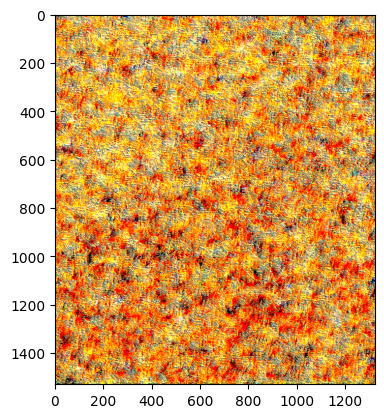

In [243]:
plt.imshow(x_unpad.squeeze().to('cpu').permute(1,2,0))
print(torch.sum(x_unpad))
# tensor(2955533., device='cuda:6')

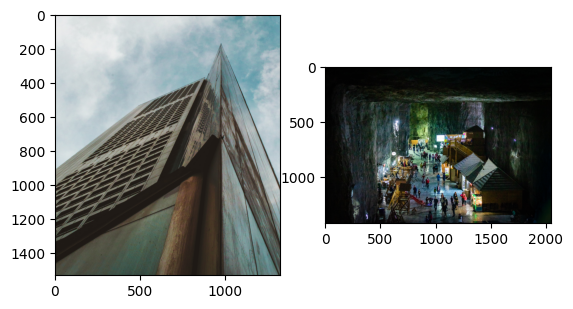

In [66]:
img1 = Image.open('../../compress_lip/Jianhao_datasets/CLIC/oscar-keys-iWNFqEYpmmo-unsplash.png')
plt.subplot(121)
plt.imshow(img1)
img2 = Image.open('../../compress_lip/Jianhao_datasets/CLIC/adrian-moise-0iRqoHHxjQk-unsplash.png')
plt.subplot(122)
plt.imshow(img2)

In [64]:
# Implement a MU-MISO channel layer
class CHN_MU_MISO(nn.Module):
    """
    U: Number of users.
    Nt: Number of transmitter antennas.
    W: Nt x U matrix. Each column is a beamforming vector.
    H: Nt x U matrix. Each column is a channel vector.
    P: N x 1 vector. Each element is a power allocated to a user.
    p_noise: N x 1 vector. Each element is a complex-noise power for a user.
    """
    def __init__(self, U, Nt, W, H, P, p_noise):
        super(CHN_MU_MISO, self).__init__()
        p_noise_ = torch.Tensor(p_noise)/2
        stddev = p_noise_**(0.5)
        self.U = U
        self.Nt = Nt
        self.W = W
        self.H = H
        self.P = P
        self.stddev = stddev
        v = sum(abs(torch.norm(self.W,dim=0)-1))
        if v>1e-5:
            warnings.warn(f"Non-unit beamforming vector: {v}")
    def forward(self, x):
        """
        x: U x Batch x CWH tensor. concatenated input of all users.
        """
        # beamforming vector weighted signals
        # for user 1:
        combined_signal = 0
        for u in range(self.U):
            combined_signal += torch.stack([(self.P[u])**(0.5)*x[u]*self.W[nt,u] for nt in range(self.Nt)])
        # combined_signal: Nt x Batch x CWH
        print("combined_signal: ", combined_signal.shape)
        y = []
        for u in range(self.U):
            # transmit to u-th user
            received_signal = torch.stack([combined_signal[nt]*self.H[nt,u] for nt in range(self.Nt)])
            received_signal = torch.sum(received_signal,dim=0)
            print("received_signal: ", received_signal.shape)
            noise = torch.normal(0, self.stddev[u], size=received_signal.shape).to(received_signal.device)
            received_signal += noise
            amp_gain = (self.P[u])**(0.5)*(self.H[:,u]@self.W[:,u]).item()
            decoded_signal = received_signal/amp_gain
            y.append(decoded_signal)
        y = torch.stack(y)
        return y
Nt = 3
U = 2
W = F.normalize(torch.randn(Nt,U),dim=0)
H = torch.randn(Nt,U)
P = [1,1]
p_noise = [0.1,0.1]
mu_simo = CHN_MU_MISO(U,Nt,W,H,P,p_noise)



combined_signal:  torch.Size([3, 64, 3, 256, 256])
received_signal:  torch.Size([64, 3, 256, 256])
received_signal:  torch.Size([64, 3, 256, 256])


In [60]:
W = F.normalize(torch.randn(Nt,U),dim=0)
H = torch.randn(Nt,U)
P = [1,1]
p_noise = [0.1,0.1]
# compute SINR
sinr = []
for u in range(U):
    signal_power = P[u]*(W[:,u]@H[:,u])**2
    

tensor([[0.1798, 0.2068],
        [2.5344, 2.6688]])
tensor([[-0.1534,  0.2633],
        [-0.5263,  1.3925]])
tensor([[0.1717, 0.2011],
        [2.5401, 2.6659]])
tensor([[  633.1013, -4968.4062],
        [ -181.0595,  3678.0920]])
